#  Automated Brazilian Daily Inflation Forecast - Next 2 Years
## Based on Brazilian Central Bank Expectations (Next 2 years)

#### Developed by Leonardo Travagini Delboni

#### Special thanks to the following libraries:
* [Pandas Library](https://pandas.pydata.org/docs/reference/frame.html)
* [python-bcb by Wilson Freitas](https://wilsonfreitas.github.io/python-bcb/index.html)

In [1]:
# install libs   # API DO BANCO CENTRAL 
# ! pip install python-bcb

In [2]:
#import bcb lib| # Brazilian Central Bank APIs (bcb)
import pandas as pd
from bcb import Expectativas
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
# Describing all available APIs from bcb library:
Expectativas().describe()


EntitySets:
  ExpectativasMercadoTop5Anuais
  ExpectativasMercadoInstituicoes
  ExpectativaMercadoMensais
  ExpectativasMercadoInflacao12Meses
  ExpectativasMercadoSelic
  ExpectativasMercadoTop5Selic
  ExpectativasMercadoTop5Mensais
  ExpectativasMercadoTrimestrais
  ExpectativasMercadoAnuais


In [5]:
# Choosing the wished API from those displayed on the terminal:
exp = Expectativas().get_endpoint("ExpectativaMercadoMensais")

In [6]:
# Chosing the parameters as per the chosen API
filter_baseCalculo = "0"
filter_Indicador = "IPCA"
filter_limite = "24"

# Getting data (type Dataframe -- Pandas) from BCB library as per the inputs chosen above:
data = (
  exp
    
    # internal function
    .query() 

    # filter with type indicadot and baseCalculo
    .filter(exp.Indicador == filter_Indicador, exp.baseCalculo == filter_baseCalculo) 

    # get first 24 rows
    .limit(24)

    # select specific colunms
    .select(exp.DataReferencia, exp.Media)

    # return results
    .collect()
);

## Converting column to datetime type

In [7]:
data['DataReferencia'] = pd.to_datetime(data['DataReferencia'])

In [8]:
data = data.sort_values(by="DataReferencia", ascending=True)

## Getting the line angular coefficient (slope)

In [9]:
import calendar

In [10]:
data['Media_shifted'] = data['Media'].shift(-1)

In [11]:
data['deltaY'] = data['Media_shifted'] - data['Media']

In [12]:
data['n_days'] = data['DataReferencia'].apply(lambda x : calendar.monthrange(x.year, x.month)[1] )

In [13]:
data['coef_ang'] = data['deltaY'] / data['n_days']

In [14]:
data.head(1)

,DataReferencia,Media,Media_shifted,deltaY,n_days,coef_ang
23,2022-10-01,0.3445,0.4453,0.1008,31,0.003252


In [15]:
data['DataReferencia'][23]

Timestamp('2022-10-01 00:00:00')

In [16]:
def create_dataframe(INICIO, coef_linear, coef_ang, n_days):
    
    FIM = INICIO + timedelta(days=(n_days-1))
    
    df_aux = pd.DataFrame()

    days = pd.date_range(start=INICIO, end=FIM)

    df_aux['Date'] = days

    valor_diario = []

    for i in range(n_days):
        value = coef_linear + i * coef_ang
        valor_diario.append(value)

    df_aux['Inflation_Forecast'] = valor_diario
    
    return df_aux

In [17]:
df_full = pd.DataFrame()

# Creating 1 dataframe for every month of the 24 months, according to each amount of days per month:

for index, row in data.iterrows():
    df_aux = create_dataframe(row['DataReferencia'], row['Media'], row['coef_ang'], row['n_days'])
    df_full = pd.concat([df_full, df_aux], axis=0)

In [18]:
df_full = df_full.reset_index(drop=True)

In [19]:
df_full = df_full.dropna(axis=0)

In [20]:
df_full

,Date,Inflation_Forecast
0,2022-10-01,0.344500
1,2022-10-02,0.347752
2,2022-10-03,0.351003
3,2022-10-04,0.354255
4,2022-10-05,0.357506
...,...,...
696,2024-08-27,0.233287
697,2024-08-28,0.235710
698,2024-08-29,0.238132
699,2024-08-30,0.240555


Text(0.5, 1.0, 'Previsão diarizada futura da inflação - Próxmos 2 anos')

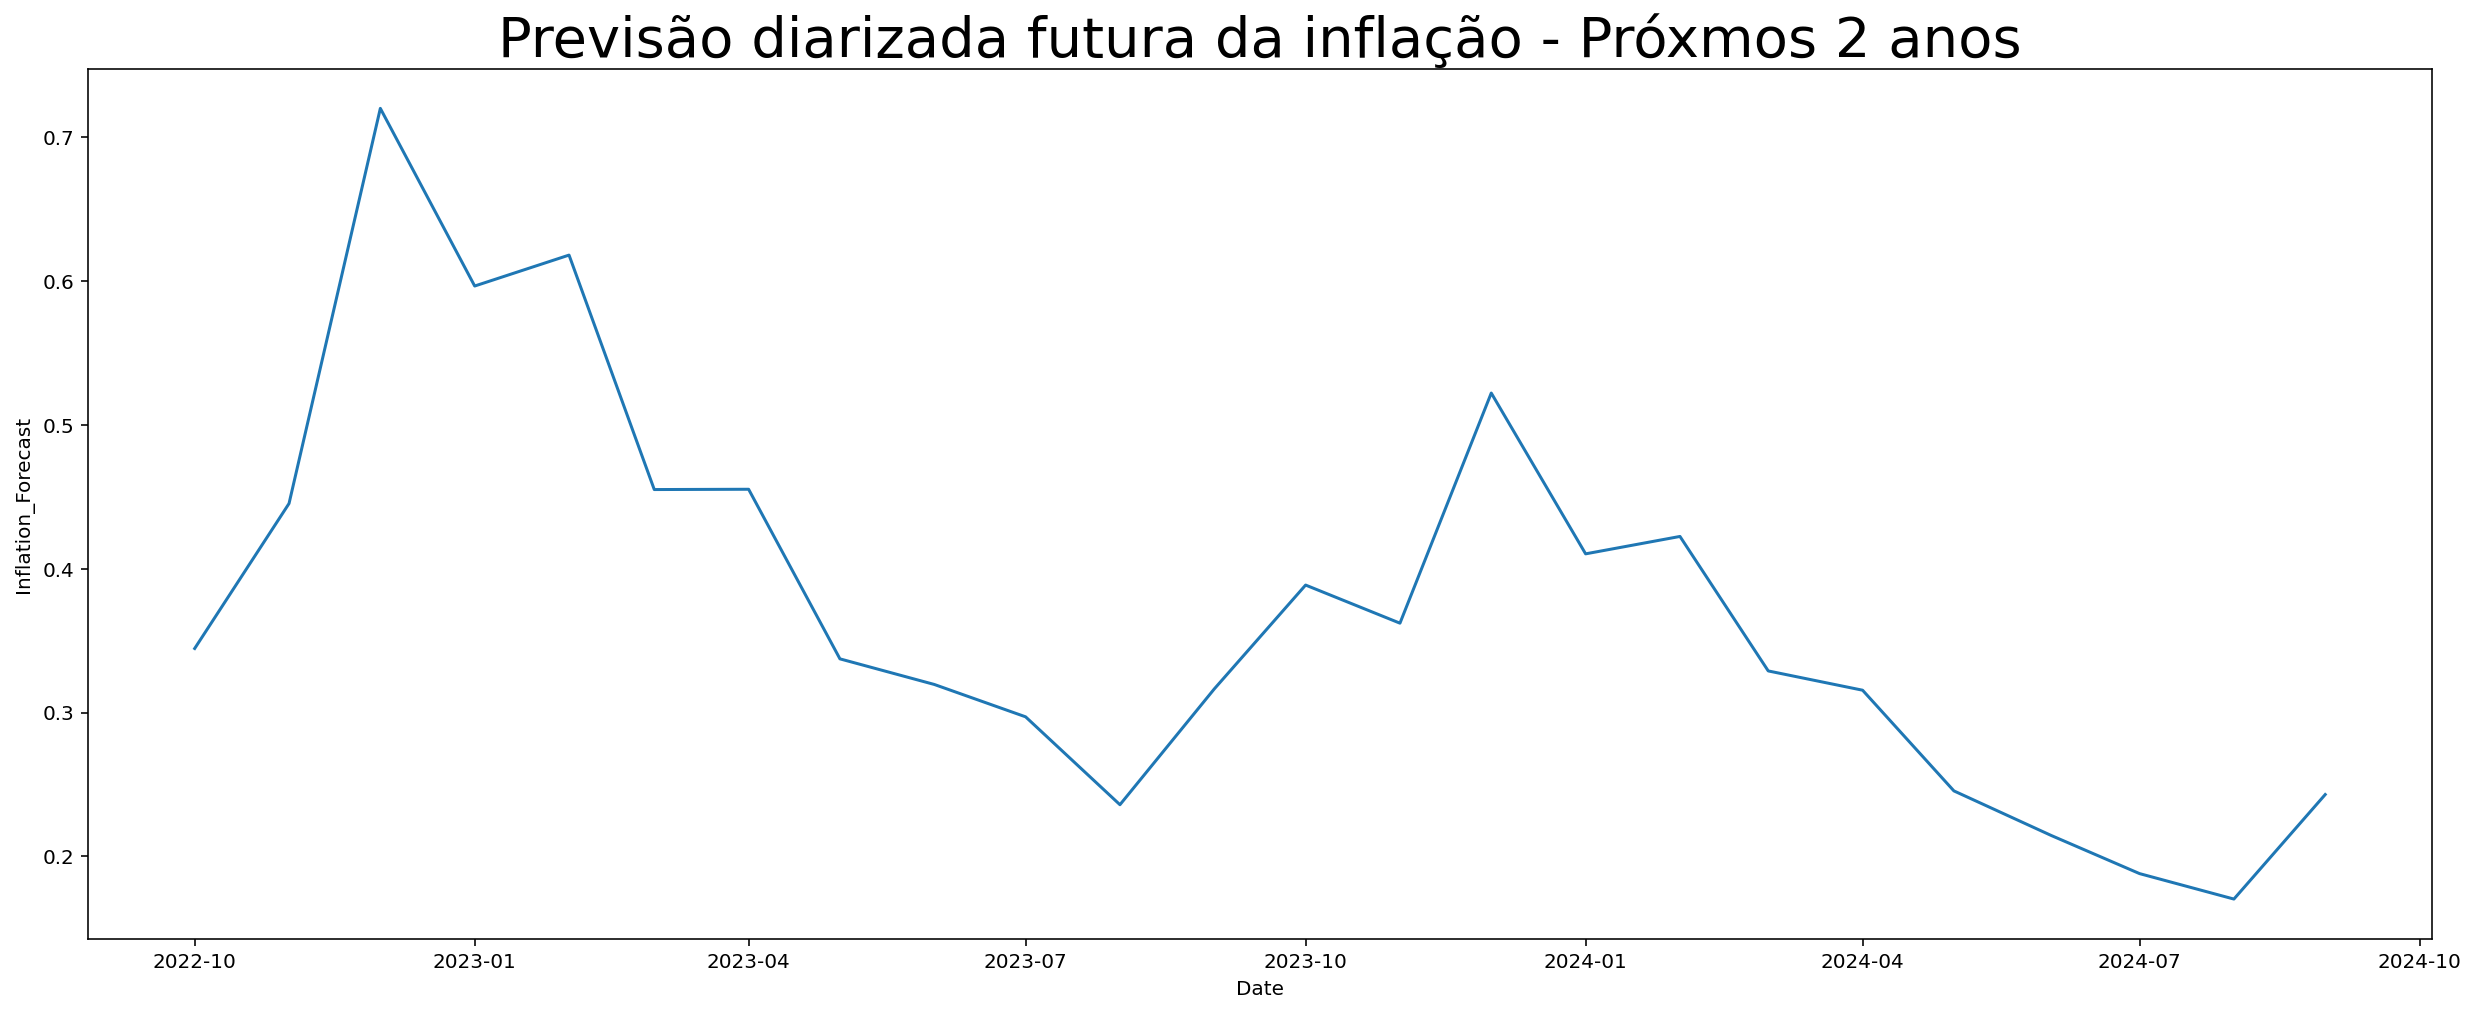

In [21]:
fig, ax = plt.subplots(figsize = (21,8))
sns.lineplot(data=df_full, x='Date', y='Inflation_Forecast', ax=ax)
plt.title("Previsão diarizada futura da inflação - Próxmos 2 anos", fontsize=28)